<a href="https://colab.research.google.com/github/drscook/REU_temp/blob/master/main_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Major improvement from v2 to v3 - More efficient handling of false collisions.  In v2, all walls reported ONE smallest positive time and we used the smallest of these.  If it resulted in a false collision, we simply didn't apply collision map or record state and move to the next step.  However, this re-computes all dt's again in next step.  This is wasteful.

In v3, all walls report ALL postitive times.  We try them from smallest to largest until we find one that gives a real collision.  This avoids re-computing dt's due to false collisions.

In [0]:
import os
import json
import numpy as np

tol = 1e-4


class Particle():
    def __init__(self, dim=2, radius=1, mass=1, gamma=1/np.sqrt(2)):
        self.dim = dim
        self.radius = radius
        self.mass = mass
        self.gamma = gamma
        self.inertia = self.mass * self.gamma * self.radius**2

    def __getitem__(self, key):
        return self.__dict__[key]

    def __setitem__(self, key, val):
        self.__dict__[key] = val


    def get_bdy_pts(self):
        try:
            return self.bdy_pts
        except:
            s = np.linspace(-np.pi, np.pi, 100)
            s = np.append(s, 0)
            self.bdy_pts = self.radius * np.array([np.cos(s), np.sin(s)])
            return self.bdy_pts


    def check_real_collision_get_arclength(self):
        arclengths = [wall.check_real_collision_get_arclength(self) for wall in Walls]
        self.arclength = np.sum(arclengths)
        if self.arclength >= 0:
            self.real_collision = True
        else:
            self.real_collision = False
            self.arclength = np.nan
        return self.real_collision

    
    def get_phi(self):
        F = Walls[self.wall_idx].get_frame(self).T
        dv = part.vel / np.linalg.norm(part.vel)
        dv_frame = dv @ F
        self.phi = np.arccos(abs(dv_frame[0])) * np.sign(dv_frame[1])
        return self.phi


    def record_state(self):
        if not hasattr(self,'vars'):  # create history
            self.vars = ['t', 'pos', 'vel', 'rot', 'spin', 'wall_idx', 'wrap_count', 'phi', 'arclength']
            for var in self.vars:
                hist = var+"_hist"
                self[hist] = []

        for var in self.vars:
            hist = var+"_hist"
            cur = self[var]
            try:
                self[hist].append(cur.copy())
            except:
                self[hist].append(cur)


    def clean_up(self):
        for key, val in self.__dict__.items():
            if isinstance(val, list) or isinstance(val, np.ndarray):
                try:
                    self[key] = np.asarray(val).astype(np.float32)
                except:
                    pass
        return json.dumps(self.__dict__, cls=MyEncoder, indent=2)


class MyEncoder(json.JSONEncoder):
    def default(self, z):
        if isinstance(z, np.ndarray):
            return z.tolist()
        elif isinstance(z, np.int64):
            return int(z)
        else:
            return super().default(z)


class Wall():
    def __getitem__(self, key):
        return self.__dict__[key]

    def __setitem__(self, key, val):
        self.__dict__[key] = val
    
    def specular_law(self, part):
        """
        Applies specular collision law v_out = v_in - 2*(v_in @ normal)normal.
        """
        n = self.get_normal(part)
        part.vel -= 2 * (n @ part.vel) * n
        return part.vel
        
        
    def wrap_law(self, part):
        """
        Applies wrap around law
        """

        # To make images look right, we must record state both before and after wrapping.
        # But we can't record arclength and phi both times - this woudl double count these collisions.
        # So we must be careful - the fix is a little delicate.
        # At this point, we have computed new arclength, but not new phi.
        # So, for the first record, we report correct new arclength but phi = nan.
        # For the second record, we report arclength = nan and correct new phi.
        # We will drop nan's when computing statistics later, so that exactly one arclength and phi
        # remains from this collision.
        part.phi = np.nan
        part.record_state()
        part.arclength = np.nan
        # Second record step will be the usual one that happens in fuction next_state.

        # Perform wrap around
        old = self.wall_idx  # wall_idx that was hit and wrapping away from
        new = self.wrap_wall_idx  # wall_idx wrapping to
        part.wall_idx = new  # tell part its new wall_idx
        part.wrap_count[old] += 1
        part.wrap_count[new] -= 1
        
        # Get frames for old and new walls
        F_old = self.axes.T
        F_new = Walls[new].axes.T

        # Compute new position
        dx_old = self.base - part.pos  # dx_old in standard coordinates
        dx_frame_old = dx_old @ F_old  # dx_old in frame coordinates
        dx_frame_new = dx_frame_old.copy()   # dx_new in frame coordinates
        dx_frame_new[0] *= -1  # flips normal coordinate so particle appears on correct side of new wall
        if self.flip_pos:
            dx_frame_new[1] *= -1  # optionally flips tangential coordinate in case old and new walls have tangents going in different directions
        dx_new = F_new @ dx_frame_new  # dx_new in standard coordinates
        part.pos = dx_new + Walls[new].base  # new part positions

        # Compute new velocity
        dv_frame_old = part.vel @ F_old  # vel_old in frame coordinates
        dv_frame_new = dv_frame_old.copy()
        dv_frame_new[0] *= -1  # flips normal coordinate so particle is moving toward correct side of new wall
        if self.flip_vel:
            dv_frame_new[1] *= -1  # optionally flips tangential coordinate in case old and new walls have tangents going in different directions
        part.vel = F_new @ dv_frame_new  # vel_new in standard coordinates
        
        
    def assign_law(self):
        """
        Defines wall method "resolve_collision" for specified collision_law
        """
        if self.collision_law_name == "specular":
            self.resolve_collision = self.specular_law
        elif self.collision_law_name == "wrap":
            if self.wall_type != 'flat':
                raise Exception('Wrap_law only defined for flat walls (currently)')
            if self.wrap_wall_idx is None:
                raise Exception("Must specify wrap_wall_idx to use wrap_law")
            if self.hard:
                # Wrap_law should usually use a soft wall so particle center can reach the wall; otherwise it will jump.
                # Ask user if we should switch to a soft wall
                make_soft = input("Wall assigned wrap wall and hard=True.  Particle will stop before the wall and jump to wrap wall.  Do you want me to make it a soft wall (y/n)?")
                if make_soft in ['y', 'Y', 'yes', 'YES', 'Yes']:
                    self.hard = False
            self.resolve_collision = self.wrap_law
        else:
            raise Exception(f"Unknown collision law {self.collision_law_name} specified")

            
    def extend_frame(self, A):
        """
        An overly fancy method to extend a set of ROW vectors to an orthonormal frame.
        Recall that and orthonormal frame must contain exactly self.dim many vectors
        that are mutually orthogonal and unit length.
        
        If no vectors are supplied, returns standards unit vectors along axes.
        If one or more vectors are supplied, applies QR-factorization to:
        1. make supplied vectors mutually orthogonal and unit length
        2. generate additional vectors that are orthogonal and unit length if fewer than
        self.dim many vectors were supplied.
        """
        
        A = np.asarray(A)
        if A.ndim == 0:
            return np.eye(self.dim)
        elif A.ndim == 1:
            A = A[:,np.newaxis]  # make into 2D-array
            
        # Though we store vectors are ROWS of A, np.linalg.qr wants them as columns.
        # So we tranpose if nrows <= ncols
        m, n = A.shape
        if m <= n:  
            A = A.T
            m, n = n, m
        
        # The heavy lifting to apply QR-factorization.
        # Flag 'complete' asks np.linalg.qr to generate additional vectors if necessary.
        F = np.linalg.qr(A, 'complete')[0]
        F = F.T
        
        # np.linalg.qr might flip the sign of vectors supplied in A.  We flip them back.
        s = np.sign(F@A)
        F[:n] *= np.diag(s).reshape(-1,1)
        
        return F

           
    def cap_endpoints(self, Walls):
        """
        The collision detection methods .get_dts of partial walls in interior of billiard cell
        can be fooled by nearly tangentially incoming particle trajectories.  We prevent
        this by placing hard half-circle caps of radius 0 at the walls endpoint.
        The vector between last 2 walls points is the first axes vector (north)."
        """
        
        # get bdy_pts to determine where endpoints are and what the "north" axes is
        bdy_pts = self.get_bdy_pts().T
        
        north = bdy_pts[0] - bdy_pts[1]
        new_wall = SphereWall(base=bdy_pts[0], radius=0.0, axes=[north],
                              max_polar_angle=np.pi/2*1.01, outside=True, inside=False)
        Walls.append(new_wall)
        
        north = bdy_pts[-1] - bdy_pts[-2]
        new_wall = SphereWall(base=bdy_pts[-1], radius=0.0, axes=[north],
                              max_polar_angle=np.pi/2*1.01, outside=True, inside=False)
        Walls.append(new_wall)
        return Walls

        
class FlatWall(Wall):
    def __init__(self, base, length, axes=None, collision_law="specular", 
                 hard=True, two_sided=False,
                 wrap_wall_idx=None, flip_pos=False, flip_vel=False):
        self.wall_type = 'flat'
        self.collision_law_name = collision_law
        self.base = np.array(base)
        self.dim = len(self.base)
        self.two_sided = two_sided
        self.hard = hard
        self.length = length
        self.total_arclength = 2 * self.length
        if self.two_sided:
            self.total_arclength *= 2
        
        self.axes = self.extend_frame(axes)
        self.normal = self.axes[0]
        self.tangent = self.axes[1:]
        
        self.wrap_wall_idx = wrap_wall_idx
        self.flip_pos = flip_pos
        self.flip_vel = flip_vel
        self.assign_law()

    def get_normal(self, part):
        return self.normal

    def get_frame(self, part):
        return self.axes

    def get_dts(self, part):
        c1 = part.vel @ self.normal
        if abs(c1) < tol:
            self.dt = []
        else:
            dx = self.base - part.pos
            dx_normal = dx @ self.normal
            T = []
            r = part.radius * self.hard
            for R in {r, -r}:
                c0 = dx_normal - R
                T.append(c0 / c1)
            if len(T) == 0:
                self.dt = []
            else:
                self.dt = np.array(T)
                if self.wall_idx == part.wall_idx:
                    idx = np.argmin(np.abs(self.dt))
                    self.dt[idx] = np.inf
                idx = (self.dt < 0)
                self.dt[idx] = np.inf
        return self.dt

                
    def check_real_collision_get_arclength(self, part):
        if self.wall_idx < part.wall_idx:
            self.arclength = self.total_arclength
        elif self.wall_idx > part.wall_idx:
            self.arclength = 0
        else:
            dx = self.base - part.pos
            F = self.axes.T
            dx_frame = dx @ F
            if np.abs(dx_frame[1]) > self.length:
                self.arclength = -np.inf
            else:
                self.arclength = dx_frame[1] + self.length
                
            if self.two_sided and dx_frame[0] >= 0:
                self.arclength += self.total_arclength / 2
        return self.arclength
    
    
    def get_bdy_pts(self):
        try:  # returns bdy_pts if previously computed
            return self.bdy_pts
        except:
            s = np.linspace(-self.length, self.length, 100)
            self.bdy_pts = (self.base + self.tangent * s[:,np.newaxis]).T
            return self.bdy_pts

                
class SphereWall(Wall):
    def __init__(self, base, radius, axes=None, max_polar_angle=np.pi,
                 collision_law="specular", wrap_wall_idx=None, hard=True,
                 inside=False, outside=False):
        self.wall_type = 'sphere'
        self.collision_law_name = collision_law
        self.base = np.array(base)
        self.dim = len(self.base)
        self.hard = hard
        self.radius = radius
        self.axes = self.extend_frame(axes)
        assert 0 <= max_polar_angle <= np.pi, f"max_polar_angle must lie between 0 and pi; got {max_polar_angle}"
        self.max_polar_angle = max_polar_angle
        self.max_normal_projection = -np.cos(max_polar_angle)
        self.hole_radius = self.radius * np.sin(np.pi - self.max_polar_angle)
        self.two_sided = (self.hole_radius> part.radius)
        if self.two_sided:
            self.inside = True
            self.outside = True
        else:
            self.inside = inside
            self.outside = outside
            assert self.inside or self.outside, f"At least one of inside or outside must be explicitly set True because hole is too small for particle to pass through."
                
        self.inside_arclength = 2 * self.max_polar_angle * self.inside * (self.radius - part.radius * self.hard)
        self.outside_arclength = 2 * self.max_polar_angle * self.outside * (self.radius + part.radius * self.hard)
        self.total_arclength = self.inside_arclength + self.outside_arclength
        self.wrap_wall_idx = wrap_wall_idx
        self.assign_law()
    
    
    def get_normal(self, part):
        dx = self.base - part.pos
        return dx / np.linalg.norm(dx)
    
    
    def get_frame(self, part):
        n = self.get_normal(part)
        return self.extend_frame(n)

    
    def get_dts(self, part):
        dx = self.base - part.pos
        dv = part.vel
        c2 = dv @ dv
        c1 = -2 * dx @ dv
        
        T = []
        r = part.radius * self.hard
        for R in {self.radius + r, self.radius - r}:
            if R < 0:
                continue
            c0 = dx @ dx - R**2
            if abs(c2) < tol:
                if abs(c1) > tol:
                    t = c0 / c1
                    T.append(t)
            else:
                d = c1**2 - 4 * c2 * c0
                if d >= 0:
                    s = np.sqrt(d)
                    T.append((-c1 + s) / (2 * c2))
                    T.append((-c1 - s) / (2 * c2))
        if len(T) == 0:
            self.dt = [np.inf]
        else:
            self.dt = np.array(T)
            if self.wall_idx == part.wall_idx:
                idx = np.argmin(np.abs(self.dt))
                self.dt[idx] = np.inf
            idx = (self.dt < 0)
            self.dt[idx] = np.inf
        return self.dt

    
    def check_real_collision_get_arclength(self, part):
        if self.wall_idx < part.wall_idx:
            self.arclength = self.total_arclength
        elif self.wall_idx > part.wall_idx:
            self.arclength = 0
        else:
            dx = self.base - part.pos
            mag = np.linalg.norm(dx)
            dx /= mag
            F = self.axes.T
            dx_frame = dx @ F
            if dx_frame[0] > self.max_normal_projection:
                self.arclength = -np.inf
            else:
                polar_angle = (np.pi - np.arccos(dx_frame[0])) * np.sign(dx_frame[1])
                if mag < self.radius:
                    self.arclength = (polar_angle + self.max_polar_angle) * (self.radius - part.radius * self.hard)
                else:
                    self.arclength = (polar_angle + self.max_polar_angle) * (self.radius + part.radius * self.hard)
                    self.arclength += self.inside_arclength
        return self.arclength
        

    def get_bdy_pts(self):
        try:
            return bdy_pts
        except:
            s = np.linspace(-self.max_polar_angle, self.max_polar_angle, 100)
            self.bdy_pts = np.array([np.cos(s), np.sin(s)]) * self.radius
            self.bdy_pts = self.axes.T @ self.bdy_pts
            self.bdy_pts += self.base[:,np.newaxis]
            return self.bdy_pts
                
            

    
    
                                
def initialize(part, Walls):
    for i in range(len(Walls)):
        Walls[i].wall_idx = i
    part.wall_bdy_pts = np.array([wall.get_bdy_pts() for wall in Walls])
    part.get_bdy_pts()

    start_wall = Walls[polygon_sides]
    part.wall_idx = start_wall.wall_idx

    # particle's initial position will be against the scatterer at angle theta to the positive x-axis
    theta = np.random.rand() * np.pi / 4  
    part.pos = np.array([np.cos(theta), np.sin(theta)]) * (part.radius + start_wall.radius)


    # particle's initial velocity will be at angle phi to the normal vector at intial position
    a = np.random.rand()  # between 0 and 1
    a = 2*a - 1  # between -1 and +1
#     phi =  a * np.pi / 2  #between -pi/2 and +pi/2
    phi =  np.arcsin(a)  # Follows the cosine law, the invariant measure for the billiard map


    # Now, we need to get a normal vector to the scatterer at intitial position.
    n = -1*start_wall.get_normal(part)


    # Now, we want to rotate it by angle phi.  So, create the rotation matrix.
    R = np.array([[np.cos(phi), -np.sin(phi)],
                  [np.sin(phi), np.cos(phi)]
                 ])

    # Apply it to n
    part.vel = R@n
    
    part.spin = 1.0
    part.rot = 0.0
    part.t = 0
    part.check_real_collision_get_arclength()
    part.get_phi()
    part.wrap_count = np.zeros(len(Walls), int)
    return part, Walls



def next_state(part, Walls):
    # get dts from each wall; each wall may return 0, 1, or many.  M = most dt's reported by a single wall
    L = [len(wall.get_dts(part)) for wall in Walls]  # computes dts at each wall and records how many dts each wall reports
    N = max(L)
    M = len(Walls)
    DT = np.full(shape=(M,N), fill_value=np.inf)  # array to hold dts from wall i in row i
    for i, l in enumerate(L):
        DT[i, :l] = Walls[i].dt  # write dt's from wall i in row i

    DT[DT < 0] = np.inf  # set any negative's to np.inf

    # attempt to move using the smallest dt and check if its a real collision.  If not, move back, set that dt to np.inf, and try again
    for attempt in range(100):
        row, col = np.unravel_index(DT.argmin(), DT.shape)  # What slot contains the smallest positive time
        part.dt = DT[row,col]
        part.wall_idx = row
        next_wall = Walls[row]

        # Move particle
        part.pos += part.vel * part.dt
        

        # check if this is a real or false collision (false = against part of wall that has been removed)
        if part.check_real_collision_get_arclength():  # if real collision, great!  We found next_state
            part.t += part.dt
            part.rot += part.spin * part.dt
            next_wall.resolve_collision(part)
            part.get_phi()
            break
        else:  # if not real collision, move the particle back and try again with next smallest dt
            part.pos -= part.vel * part.dt
            DT[row, col] = np.inf

    return part, Walls



def run(part, Walls):
    part.record_state()

    for i in range(steps):
#         print(f"step {i}")

        part, Walls = next_state(part, Walls)  # evolves the system forward one step
        part.record_state()

    return part.clean_up()

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

def draw(part, start_step=0, stop_step=None, ax=None, arrows=True):
    
    t_hist = part['t_hist'][start_step:stop_step]
    pos_hist = part['pos_hist'][start_step:stop_step]
    vel_hist = part['vel_hist'][start_step:stop_step]
    rot_hist = part['rot_hist'][start_step:stop_step]
    t = t_hist[-1]
    pos = pos_hist[-1]
    vel = vel_hist[-1]
    rot = rot_hist[-1]

    if ax is None:   # May pass in ax to overlay plots
        fig, ax = plt.subplots(figsize=(5,5))
        ax.set_aspect('equal')
        ax.grid(False)

    for bdy in part['wall_bdy_pts']:
        ax.plot(*bdy, 'k', linewidth=3.0)

    R = np.array([[np.cos(rot), -np.sin(rot)],[np.sin(rot), np.cos(rot)]])
    bdy = R @ part['bdy_pts'] + pos[:,np.newaxis]
    ax.plot(*bdy)

#     Draw arrow for velocity
    arr = vel / np.linalg.norm(vel) * part['radius'] * 2
    ax.annotate("", xy=pos, xytext=pos+arr, arrowprops=dict(arrowstyle="<-"))

    steps = len(pos_hist)
    if steps > 1:
        dt = np.abs(np.diff(t_hist))
        big_steps = np.nonzero(dt > tol)[0].tolist()
        for i in big_steps:
            ax.plot(pos_hist[i:i+2,0], pos_hist[i:i+2,1], 'g:')
        if arrows:
            midpoints = (pos_hist[1:] + pos_hist[:-1]) / 2
            vec = pos_hist[1:] - pos_hist[:-1]
            mag = np.linalg.norm(vec, axis=1, keepdims=True)
            vec /= mag
            vec *= (mag.min() / 2)
            for i in big_steps:
                ax.quiver(midpoints[i,0], midpoints[i,1], vec[i,0], vec[i,1])
    return ax

In [0]:
from copy import deepcopy
from IPython.display import HTML
import io
import base64
import matplotlib.pyplot as plt
from matplotlib import animation, rc
%matplotlib inline


def interpolate(part, frame_count=100):
    pos_hist = part['pos_hist']
    t_hist   = part['t_hist']
    
    dist = np.linalg.norm(pos_hist, axis=-1)
    cum_dist = np.cumsum(dist)
    max_flight = np.linalg.norm(np.ptp(pos_hist, axis=0))
    max_flight_frame = max_flight / 25
    max_cum_dist = max_flight_frame * frame_count
    idx = cum_dist < max_cum_dist
    
    pos_hist = pos_hist[idx]
    t_hist   = t_hist[idx] - t_hist[0]
    vel_hist = part['vel_hist'][idx]
    rot_hist = part['rot_hist'][idx]
    spin_hist = part['spin_hist'][idx]
    
    dt_frame_ave = t_hist[-1] / frame_count
    dt_collision = np.diff(t_hist)
    frames_interp = np.ceil(dt_collision / dt_frame_ave).astype(int)
    frames_interp[frames_interp < 1] = 1
    
    dt = np.append(dt_collision / frames_interp, 0)

    def interp(x):
        x_interp = np.repeat(x[:-1], frames_interp, axis=0)    
        x_interp = np.append(x_interp, x[[-1]], axis=0)
        return x_interp

    part_interp = deepcopy(part)
    part['dt_interp']   = np.hstack([dt * np.arange(f) for dt, f in zip(dt, frames_interp)]+[0])
    part['t_interp']    = interp(t_hist) + part['dt_interp']
    part['vel_interp']  = interp(vel_hist)
    part['spin_interp'] = interp(spin_hist)
    part['pos_interp']  = interp(pos_hist)
    part['pos_interp']  += part['vel_interp'] * part['dt_interp'][:,np.newaxis]
    theta  = interp(rot_hist)
    theta  += part['spin_interp'] * part['dt_interp']#[:,np.newaxis]
    part['rot_interp']  = np.moveaxis(np.array([[np.cos(theta), -np.sin(theta)],
                                              [np.sin(theta), np.cos(theta)]]
                                            ), -1, 0)
    return part


def embed_video(fname):
    video = io.open(fname, 'r+b').read()
    encoded = base64.b64encode(video)

    display(HTML(data='''<video alt="test" controls>
         <source src="data:video/mp4;base64,{0}" type="video/mp4" />
         </video>'''.format(encoded.decode('ascii'))))

    
def animate(part, movie_time=10, frame_rate=60, show_trails=True,
           save=False, embed=True):
    interp_only = not (save or embed)
    if interp_only:
        print("Only doing interpolation because both save and embed are false.")
    
    frame_count = movie_time * frame_rate
    print(f"I will attempt to animate {frame_count} frames")
    
    part = interpolate(part, frame_count)
    
    t = part['t_interp']
    pos = part['pos_interp']
    rot = part['rot_interp']
    dt = np.abs(np.diff(t))
    steps = len(dt)
    big_steps = np.nonzero(dt > tol)[0].tolist()
    
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.set_facecolor('w')
    
    for bdy in part['wall_bdy_pts']:
        ax.plot(*bdy, 'k', linewidth=3.0)

    time_text = ax.text(0.02, 0.98, '', transform=ax.transAxes)
    bdy_pts = part['bdy_pts']
    bdy = ax.plot([],[], 'r', linewidth=1.0)[0]
    
    trails = []
    for i in range(steps):
        trails.append(ax.plot(pos[i:i+2,0], pos[i:i+2,1], 'g:', alpha=0.0)[0])
    
    def init():
        time_text.set_text('')
        bdy.set_data(rot[0] @ bdy_pts + pos[[0]].T)
        return [bdy] + trails


    def update(s):
        time_text.set_text(f"time {t[s]:.2f}")
        bdy.set_data(rot[s] @ bdy_pts + pos[[s]].T)
        if show_trails:
            for i in big_steps:
                if i >= s:
                    break
                trails[i].set_alpha(1.0)
        return [bdy] + trails

    anim = animation.FuncAnimation(fig, update, init_func=init,
                                   frames=frame_count, interval=movie_time*1000/frame_count, 
                                   blit=True)
    plt.close()

    if save:
        anim_filename = 'animation.mp4'
        try:
            anim.save(filename=anim_filename)    # save animation as mp4
        except:
            install = input("First animation attempt failed.  Shall I try to install ffmpeg and try again (y/n)?")
            if install in ['y', 'Y', 'yes', 'Yes', 'YES']:
                os.system('add-apt-repository ppa:mc3man/trusty-media ')
                os.system('apt-get update')
                os.system('apt-get install --upgrade ffmpeg')
                os.system('apt-get install --upgrade frei0r-plugins')
                anim.save(filename=anim_filename)    # save animation as mp4
            else:
                print("OK, I give up.  Returning the anim object.")
                return anim
        if embed:
            embed_video(anim_filename)    # show in notebook - resizing issues
    elif embed:
        display(HTML(anim.to_jshtml()))        # diplays video in notebook

    return part, anim


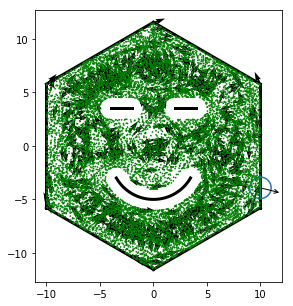

I will attempt to animate 200 frames


In [9]:
## Wrap Law

np.random.seed(5)  # produces the same thing every thing - easier for debugging

steps = 5000
dim = 2

part = Particle(radius=1.0)

Walls = []
polygon_sides = 6
polygon_radius_inscribed = 10
assert polygon_sides % 2 == 0, "I only know how to wrap with an even number of sides"
offset = int(polygon_sides / 2)

length = np.tan(np.pi / polygon_sides) * polygon_radius_inscribed
for i, theta in enumerate(np.linspace(0, 2*np.pi, polygon_sides, endpoint=False)):
    v = np.array([np.cos(theta), np.sin(theta)])
    b = v * polygon_radius_inscribed
    n = -1 * v
    t = [n[1], -n[0]]
    axes = [n, t]
    wrap_wall_idx = (i + offset) % polygon_sides
    new_wall = FlatWall(base=b, axes=axes, length=length, collision_law='wrap',
                        wrap_wall_idx=wrap_wall_idx, hard=False, flip_vel=True)
    Walls.append(new_wall)


scatterer_radius = 4
assert (scatterer_radius < polygon_radius_inscribed), "scatterer won't fit in the polygon"  # checks that the scatterer fits
new_wall = SphereWall(base=[0.0, -1.0], radius=scatterer_radius, max_polar_angle = np.pi/3,
                      axes=[[0,-1],[1,0]])
Walls.append(new_wall)
if new_wall.max_polar_angle < np.pi:
    new_wall.cap_endpoints(Walls)


new_wall = FlatWall(base=[-3.0,3.5], axes=[0,1], length=1, two_sided=True)
Walls.append(new_wall)
new_wall.cap_endpoints(Walls)

new_wall = FlatWall(base=[3.0,3.51], axes=[0,1], length=1, two_sided=True)
Walls.append(new_wall)
new_wall.cap_endpoints(Walls)

part, Walls = initialize(part, Walls)

json_record = run(part, Walls)

del part

part = json.loads(json_record)
for key, val in part.items():
    if isinstance(val, list):
        part[key] = np.array(val)

ax = draw(part, stop_step=1000)
plt.show()

part, anim = animate(part, movie_time=10, frame_rate=20, show_trails=True, save=True)

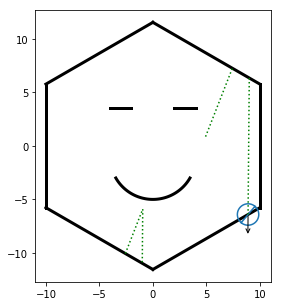

In [8]:
#@title Interactive {run: "auto"}
plot_steps =6 #@param {type:"slider", min:0, max:50, step:1}

ax = draw(part, stop_step=plot_steps+1, arrows=False)
plt.show()

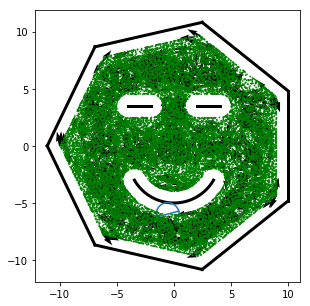

I will attempt to animate 200 frames


In [23]:
## Hard walls

np.random.seed(5)  # produces the same thing every thing - easier for debugging

steps = 5000
dim = 2

part = Particle(radius=1.0)

Walls = []
polygon_sides = 7
polygon_radius_inscribed = 10
offset = int(polygon_sides / 2)

length = np.tan(np.pi / polygon_sides) * polygon_radius_inscribed
for i, theta in enumerate(np.linspace(0, 2*np.pi, polygon_sides, endpoint=False)):
    v = np.array([np.cos(theta), np.sin(theta)])
    b = v * polygon_radius_inscribed
    n = -1 * v
    t = [n[1], -n[0]]
    axes = [n, t]
    wrap_wall_idx = (i + offset) % polygon_sides
    new_wall = FlatWall(base=b, axes=axes, length=length)
    Walls.append(new_wall)


scatterer_radius = 4
assert (scatterer_radius < polygon_radius_inscribed), "scatterer won't fit in the polygon"  # checks that the scatterer fits
new_wall = SphereWall(base=[0.0, -1.0], radius=scatterer_radius, max_polar_angle = np.pi/3,
                      axes=[[0,-1],[1,0]])
Walls.append(new_wall)
if new_wall.max_polar_angle < np.pi:
    new_wall.cap_endpoints(Walls)


new_wall = FlatWall(base=[-3.0,3.5], axes=[0,1], length=1, two_sided=True)
Walls.append(new_wall)
new_wall.cap_endpoints(Walls)

new_wall = FlatWall(base=[3.0,3.51], axes=[0,1], length=1, two_sided=True)
Walls.append(new_wall)
new_wall.cap_endpoints(Walls)

part, Walls = initialize(part, Walls)

json_record = run(part, Walls)

del part

part = json.loads(json_record)
for key, val in part.items():
    if isinstance(val, list):
        part[key] = np.array(val)

ax = draw(part, stop_step=1000)
plt.show()

part, anim = animate(part, movie_time=10, frame_rate=20, show_trails=True, save=True)

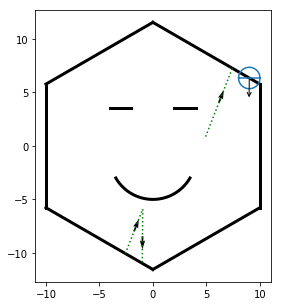

In [0]:
#@title Interactive {run: "auto"}
plot_steps =5 #@param {type:"slider", min:0, max:50, step:1}

ax = draw(state_history, Walls, stop_step=plot_steps+1, arrows=False)
plt.show()

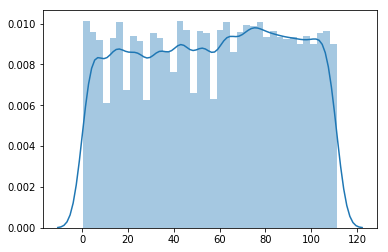

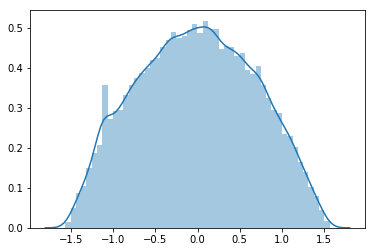

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
arc = state_history['ARCLENGTH'].copy()
arc = arc[~np.isnan(arc)]
sns.distplot(arc)
plt.show()

phi = state_history['PHI'].copy()
phi = phi[~np.isnan(phi)]
sns.distplot(phi)
plt.show()